# Load Sentinel-2 data from the CDSE STAC catalog

This notebook shows an example how to load Sentinel-2 data from the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?.language=en).

## Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac), following the [README](../../README.md).

The data can be accessed via S3, where key and secret can be obtained following the [CDSE access documentation to EO data via S3](https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets). The store object will receive the key and secret upon initialization, as demonstrated below.

Now, we first import everything we need:

In [1]:
%%time
import itertools

import matplotlib.pyplot as plt
import xarray as xr
from xcube.core.store import new_data_store, get_data_store_params_schema

from xcube_stac.utils import reproject_bbox

CPU times: user 4.93 s, sys: 338 ms, total: 5.27 s
Wall time: 3.8 s


In [2]:
xr.set_options(display_expand_attrs=False)

There are two [data stores](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework) available for the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?language=en):

- **`stac-pc-ardc`**: Allows you to open multiple STAC items and assemble them into a 3D spatiotemporal data cube.
- **`stac-pc`**: Enables you to open individual STAC items.

---
## Data store to access spatiotemporal analysis-ready data cubes 
In the following, we will first demonstrate how to use the `stac-cdse-ardc` store. To view the parameters to initialize the data store instance, execute the following cell. 

> **Note:**  
> Access requires your S3 `key` and `secret`.

In [3]:
%%time
store_params = get_data_store_params_schema("stac-pc-ardc")
store_params

CPU times: user 96.9 ms, sys: 12 ms, total: 109 ms
Wall time: 107 ms


In [4]:
%%time
store = new_data_store("stac-pc-ardc")

CPU times: user 35.3 ms, sys: 3.02 ms, total: 38.3 ms
Wall time: 483 ms


The following cell shows the available data IDs for the analysis-ready datacube mode. The data IDs point to a STAC collections.

In [5]:
%%time
data_ids = store.list_data_ids()
data_ids

CPU times: user 19 μs, sys: 2 μs, total: 21 μs
Wall time: 23.1 μs


['sentinel-2-l2a']

Below, the parameters for the `open_data` method can be viewed for a specific data ID.

In [6]:
%%time
open_params = store.get_open_data_params_schema("sentinel-2-l2a")
open_params

CPU times: user 39 μs, sys: 4 μs, total: 43 μs
Wall time: 45.1 μs


The store supports the collection `sentinel-2-l1c` and `sentinel-2-l2a`. We first get Sentinel-2 Level-1C data by assigning the `data_id` to `"sentinel-2-l1c"`. We set the bounding box to cover the greater Hamburg area and the time range to second half of July 2020.

In [7]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=[9.7, 53.3, 10.3, 53.8],
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10 / 111320, # meter in degree
    crs="EPSG:4326",
    asset_names=["B02", "B03", "B04"],
    add_angles=False,
)
ds

No raster STAC extension found for item 'S2A_MSIL2A_20200716T104031_R008_T32UNE_20201024T102606'.
Stac extension raster exists only for version 'v1' and 'v2', not for None. No scaling is applied.
Stac extension raster exists only for version 'v1' and 'v2', not for None. No scaling is applied.
Stac extension raster exists only for version 'v1' and 'v2', not for None. No scaling is applied.
No raster STAC extension found for item 'S2B_MSIL2A_20200718T102559_R108_T32UNE_20200816T160033'.
Stac extension raster exists only for version 'v1' and 'v2', not for None. No scaling is applied.
Stac extension raster exists only for version 'v1' and 'v2', not for None. No scaling is applied.
Stac extension raster exists only for version 'v1' and 'v2', not for None. No scaling is applied.
No raster STAC extension found for item 'S2B_MSIL2A_20200721T103629_R008_T32UNE_20200817T010253'.
Stac extension raster exists only for version 'v1' and 'v2', not for None. No scaling is applied.
Stac extension raste

CPU times: user 2.72 s, sys: 71.9 ms, total: 2.79 s
Wall time: 8.58 s


<xarray.Dataset> Size: 2GB
Dimensions:      (time: 7, lon: 6681, lat: 5567)
Coordinates:
  * time         (time) datetime64[ns] 56B 2020-07-16T10:40:31.024000 ... 202...
    spatial_ref  int64 8B 0
  * lon          (lon) float64 53kB 9.7 9.7 9.7 9.7 9.7 ... 10.3 10.3 10.3 10.3
  * lat          (lat) float64 45kB 53.8 53.8 53.8 53.8 ... 53.3 53.3 53.3 53.3
Data variables:
    B02          (time, lat, lon) uint16 521MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, lat, lon) uint16 521MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, lat, lon) uint16 521MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes: (3)

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.

/home/konstantin/micromamba/envs/xcube-stac/lib/python3.13/site-packages/numpy/_core/numeric.py:442: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


CPU times: user 7.4 s, sys: 2.07 s, total: 9.47 s
Wall time: 25.3 s


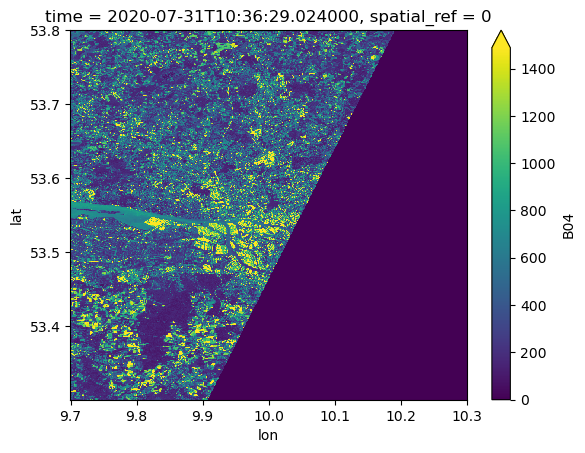

In [8]:
%%time
ds.B04.isel(time=-1)[::10, ::10].plot(robust=True)

Next we retrieve the same data cube, but for Level-2a by assigning the `data_id` to `sentinel-2-l2a`.

In [10]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=[9.7, 53.3, 10.3, 53.8],
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10 / 111320, # meter in degree
    crs="EPSG:4326",
    asset_names=["B02", "B03", "B04", "SCL"],
)
ds

CPU times: user 1.63 s, sys: 117 ms, total: 1.75 s
Wall time: 9.82 s


<xarray.Dataset> Size: 4GB
Dimensions:        (time: 7, lon: 6681, lat: 5567, angle_lon: 15,
                    angle_lat: 13, angle: 2, band: 3)
Coordinates:
  * time           (time) datetime64[ns] 56B 2020-07-16T10:40:31.024000 ... 2...
    spatial_ref    int64 8B 0
  * lon            (lon) float64 53kB 9.7 9.7 9.7 9.7 ... 10.3 10.3 10.3 10.3
  * lat            (lat) float64 45kB 53.8 53.8 53.8 53.8 ... 53.3 53.3 53.3
  * angle_lon      (angle_lon) float64 120B 9.7 9.746 9.791 ... 10.29 10.34
  * angle_lat      (angle_lat) float64 104B 53.84 53.79 53.75 ... 53.34 53.3
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL            (time, lat, lon) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    solar_angle    (angle, time, angle_lat, angle_lon) float32 11kB dask.array<chunksize=(2, 1, 13, 15), meta=np.ndarray>
    viewing_angle  (angle, band, time, angle_lat, angle_lon) float32 33kB dask.array<chunksize=(2, 3, 1, 13, 15), meta=np.ndarray>
Attributes: (3)

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.


CPU times: user 14.6 s, sys: 1.01 s, total: 15.6 s
Wall time: 19.5 s


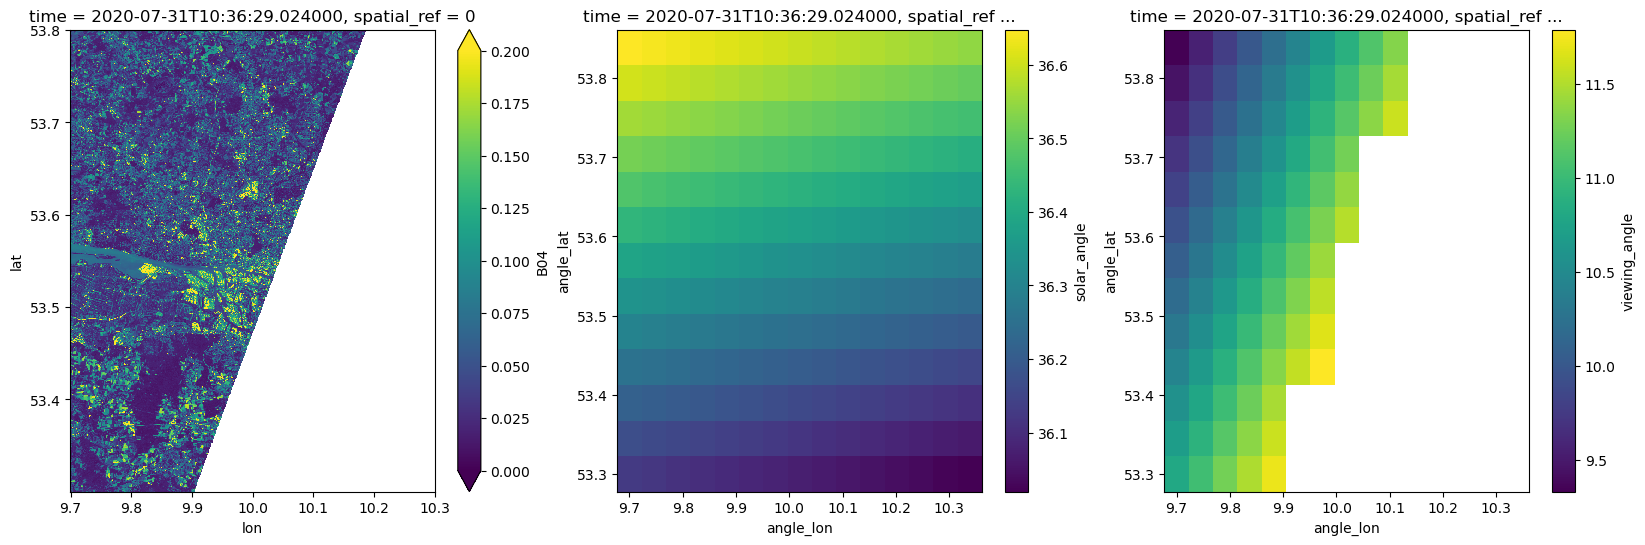

In [11]:
%%time
ds.B04.isel(time=-1)[::10, ::10].plot(vmin=0, vmax=0.2)

The data access can be sped up when requesting the data in the UTM CRS which is the native UTM of the Sentinel-2 products. 

In [12]:
%%time
bbox = [9.7, 53.3, 10.3, 53.8]
crs_target = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_target)

CPU times: user 447 μs, sys: 961 μs, total: 1.41 ms
Wall time: 732 μs


In [13]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10,
    crs=crs_target,
    asset_names=["B02", "B03", "B04", "SCL"],
    add_angles=False,
)
ds

CPU times: user 2.19 s, sys: 182 ms, total: 2.37 s
Wall time: 14.6 s


<xarray.Dataset> Size: 4GB
Dimensions:        (time: 11, y: 5619, x: 4054, angle_x: 10, angle_y: 13,
                    angle: 2, band: 3)
Coordinates:
  * time           (time) datetime64[ns] 88B 2020-07-15T10:15:59.024000 ... 2...
    spatial_ref    int64 8B 0
  * x              (x) float64 32kB 5.461e+05 5.461e+05 ... 5.866e+05 5.866e+05
  * y              (y) float64 45kB 5.962e+06 5.962e+06 ... 5.906e+06 5.906e+06
  * angle_x        (angle_x) float64 80B 5.461e+05 5.511e+05 ... 5.911e+05
  * angle_y        (angle_y) float64 104B 5.966e+06 5.961e+06 ... 5.906e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03            (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04            (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL            (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    solar_angle    (angle, time, angle_y, angle_x) float32 11kB dask.array<chunksize=(2, 1, 13, 10), meta=np.ndarray>
    viewing_angle  (angle, band, time, angle_y, angle_x) float32 34kB dask.array<chunksize=(2, 3, 1, 13, 10), meta=np.ndarray>
Attributes: (3)

Note that the search function in the CDSE STAC API is very slow. Further investigation and comparison with other STAC APIs is needed. 

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.

CPU times: user 9.34 s, sys: 783 ms, total: 10.1 s
Wall time: 11.7 s


/home/konstantin/micromamba/envs/xcube-stac/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


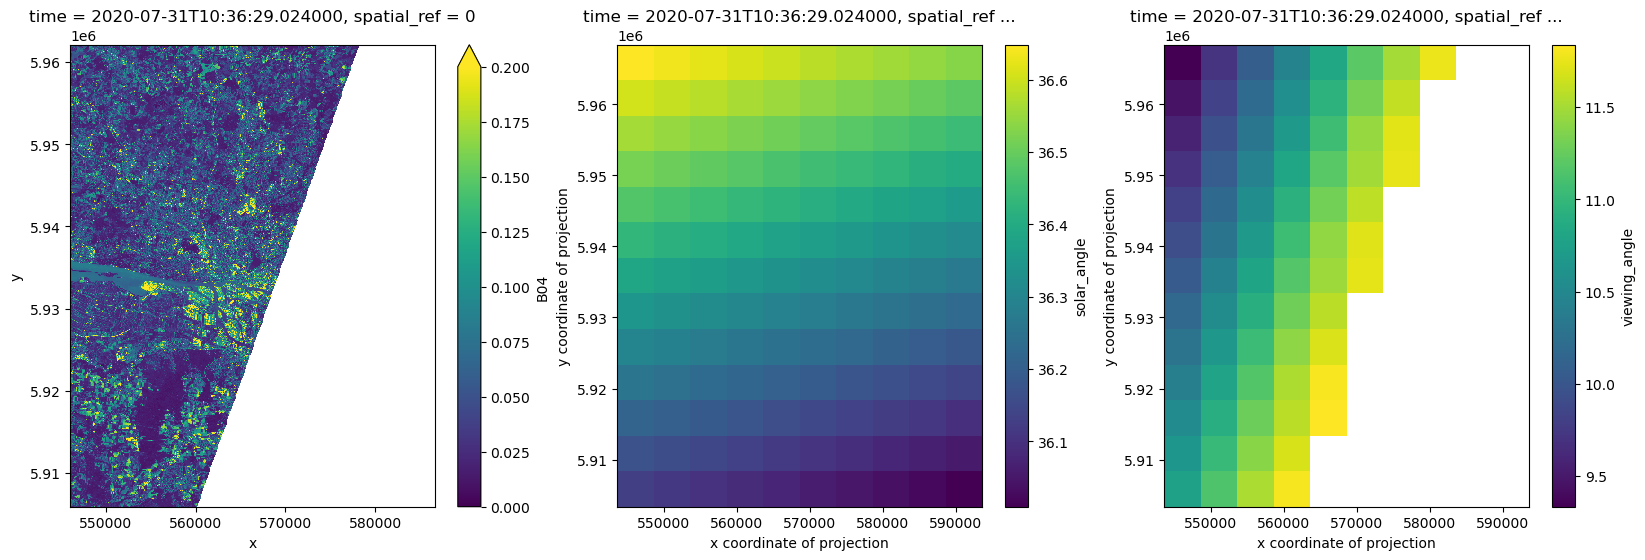

In [14]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ds.B04.isel(time=-1)[::10, ::10].plot(ax=ax[0], vmin=0, vmax=0.2)

----
## Data store to access single observations
Now, we initiate the data store to access each STAC item representing one observation tile. 

In [15]:
%%time
store = new_data_store("stac-cdse", **credentials)

CPU times: user 6.85 ms, sys: 1.07 ms, total: 7.92 ms
Wall time: 146 ms


In the next step, we can search for items using search parameters. The following code shows which search parameters are available.

In [16]:
%%time
search_params = store.get_search_params_schema()
search_params

CPU times: user 21 μs, sys: 1 μs, total: 22 μs
Wall time: 24.6 μs


 Next, we will search for tiles of Sentinel-2 data. The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL. The data IDs can be streamed using the following code where we show the first 10 data IDs as an example.

In [17]:
%%time
descriptors = list(
    store.search_data(
        collections=["sentinel-2-l2a"],
        bbox=[9, 47, 10, 48],
        time_range=["2020-07-01", "2020-07-05"],
    )
)
[d.to_dict() for d in descriptors]

CPU times: user 194 ms, sys: 6.11 ms, total: 200 ms
Wall time: 3.28 s


[{'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32UNU_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.999728, 47.755819, 10.493269, 48.753013],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32UMU_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.087776, 47.759622, 9.132783, 48.752937],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TNT_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.999733, 46.85664, 10.467277, 47.853702],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TMT_20230530T175912',
  'data_type': 'dataset',
  'bbox': [7.760786, 46.858555, 9.13047, 47.853628],
  'time_range':

In the next step, we can open the data for each data ID. The following code shows which parameters are available for opening the data.

In [18]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 34 μs, sys: 3 μs, total: 37 μs
Wall time: 38.1 μs


We select the band B04 (red), B03 (green), B02 (blue), and the science classification layer (SLC), and lazily load the corresponding data.

In [19]:
%%time
ds = store.open_data(
    "collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TMT_20230530T175912",
    asset_names=["B04", "B03", "B02", "SCL"],
    add_angles=True,
)
ds

CPU times: user 215 ms, sys: 18.6 ms, total: 234 ms
Wall time: 1.77 s


<xarray.Dataset> Size: 2GB
Dimensions:        (y: 10980, x: 10980, angle_x: 23, angle_y: 23, angle: 2,
                    band: 3)
Coordinates:
  * x              (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y              (y) float64 88kB 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
    spatial_ref    int64 8B 0
  * angle_x        (angle_x) float64 184B 4e+05 4.05e+05 ... 5.05e+05 5.1e+05
  * angle_y        (angle_y) float64 184B 5.3e+06 5.295e+06 ... 5.19e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B04            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B03            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B02            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    SCL            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    solar_angle    (angle, angle_y, angle_x) float32 4kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
    viewing_angle  (angle, band, angle_y, angle_x) float32 13kB dask.array<chunksize=(2, 3, 23, 23), meta=np.ndarray>
Attributes: (3)

We plot the loaded data as an example below.

CPU times: user 12.1 s, sys: 921 ms, total: 13.1 s
Wall time: 20 s


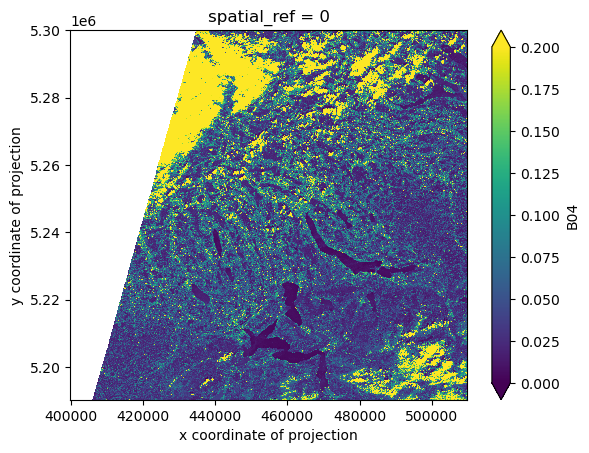

In [20]:
%%time
ds.B04[::10, ::10].plot(vmin=0.0, vmax=0.2)

Next, we do the same for Sentine-2 Level-1C. We first search in the collection `sentinel-2-l1c` and open one tile. 

In [21]:
%%time
descriptors = list(
    store.search_data(
        collections=["sentinel-2-l1c"],
        bbox=[9, 47, 10, 48],
        time_range=["2020-07-01", "2020-07-05"],
    )
)
[d.to_dict() for d in descriptors]

CPU times: user 125 ms, sys: 3.32 ms, total: 129 ms
Wall time: 3.06 s


[{'data_id': 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32UNU_20230530T084300',
  'data_type': 'dataset',
  'bbox': [8.999728, 47.755819, 10.493269, 48.753013],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32UMU_20230530T084300',
  'data_type': 'dataset',
  'bbox': [8.087776, 47.759622, 9.132783, 48.752937],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32TNT_20230530T084300',
  'data_type': 'dataset',
  'bbox': [8.999733, 46.85664, 10.467277, 47.853702],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32TMT_20230530T084300',
  'data_type': 'dataset',
  'bbox': [7.760786, 46.858555, 9.13047, 47.853628],
  'time_range':

In [22]:
%%time
ds = store.open_data(
    "collections/sentinel-2-l1c/items/S2B_MSIL1C_20200705T101559_N0500_R065_T32TMT_20230530T084300",
    asset_names=["B04", "B03", "B02"],
    add_angles=True,
)
ds

CPU times: user 160 ms, sys: 18.9 ms, total: 179 ms
Wall time: 1.57 s


<xarray.Dataset> Size: 1GB
Dimensions:        (x: 10980, y: 10980, angle_x: 23, angle_y: 23, angle: 2,
                    band: 3)
Coordinates:
  * x              (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y              (y) float64 88kB 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
    spatial_ref    int64 8B 0
  * angle_x        (angle_x) float64 184B 4e+05 4.05e+05 ... 5.05e+05 5.1e+05
  * angle_y        (angle_y) float64 184B 5.3e+06 5.295e+06 ... 5.19e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B04            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B03            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B02            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    solar_angle    (angle, angle_y, angle_x) float32 4kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
    viewing_angle  (angle, band, angle_y, angle_x) float32 13kB dask.array<chunksize=(2, 3, 23, 23), meta=np.ndarray>
Attributes: (3)

CPU times: user 11.6 s, sys: 738 ms, total: 12.3 s
Wall time: 18.1 s


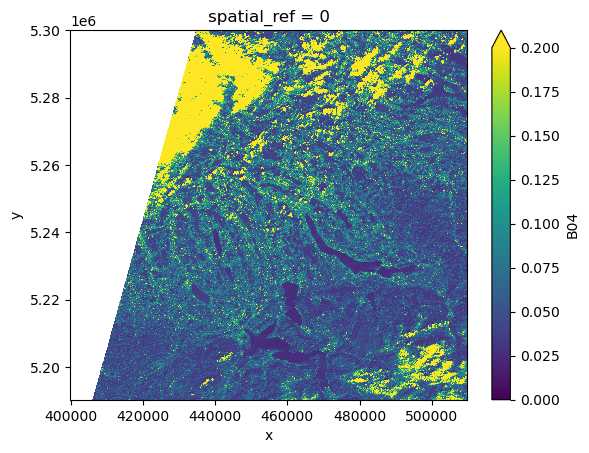

In [23]:
%%time
ds.B04[::10, ::10].plot(vmin=0.0, vmax=0.2)